In [11]:
import os, json, argparse
from random import choice
import numpy as np
import networkx as nx

from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from HEML.utils.cpet import make_histograms, construct_distance_matrix
from HEML.utils.analysis import filtered_resonance_analysis, simple_resonance_analysis
from HEML.utils.fields import compress


carbene_root = "../../../data/compressed_carbene_dicts/"
files = os.listdir(carbene_root)

sweep_root = "../../../data/sweep_test/"
output_folder = sweep_root + "sweep_out/"
# create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

sweep_folders = os.listdir(sweep_root)


In [44]:
from HEML.utils.analysis import compute_resonance_times


def get_run_number(file, run_key="run"):
    # get the run number
    run_number = file.split("-")
    # get the string with run_key in it
    run_number = [i for i in run_number if run_key in i]
    # remove the run_key
    run_number = run_number[0].replace(run_key, "")
    # convert to integer
    run_number = int(run_number)
    return run_number


def compute_resonance_times_raw(files, full_files, run_key="run"):
    """compute the resonance times for a given cluster, separated by run_key
    Takes:
        files: list of files in a cluster
        full_files: list of all files
        run_key: string that separates the run number from the rest of the file name
    """

    if len(files) <= 1:  # esp useful with filtered_resonance_analysis
        return {"mean": 1, "n_entries": 0, "max": 1}
    res_dict = {}
    # print("files: ", len(files))
    res_time_temp = 0
    for ind_file_cluster, file in enumerate(files[:-1]):
        run_number = get_run_number(file, run_key=run_key)
        next_file = files[ind_file_cluster + 1]
        next_file_run_number = get_run_number(next_file, run_key=run_key)
        # get the index of the next_file in full_files
        ind_next_file = full_files.index(next_file)
        ind_current_file = full_files.index(file)

        res_time_temp += 1
        # check if run_number is in res_dict
        if run_number not in res_dict.keys():
            res_dict[run_number] = []

        # check if the next file is the next file in full_files
        # print(ind_next_file - ind_current_file)
        if next_file_run_number != run_number:
            # if not, append the res_time_temp to the list
            res_dict[run_number].append(res_time_temp)
            # reset the res_time_temp
            res_time_temp = 0

        elif ind_next_file - ind_current_file != 1:
            # if so, append the res_time_temp to the list
            res_dict[run_number].append(res_time_temp)
            # reset the res_time_temp
            res_time_temp = 0

        elif ind_file_cluster == len(files) - 2:
            # if so, append the res_time_temp to the list
            res_dict[run_number].append(res_time_temp)

    res_time = []
    # each res_dict merge the lists
    for k, v in res_dict.items():
        res_time.extend(v)
    return res_time


def simple_resonance_analysis_raw(compress_dictionary, run_key="run"):
    """
    Computes simple statistics on mean and std of resonance times in each cluster
    """
    # first go through each cluster and collect the names of the files and order them
    full_files = []
    for k, v in compress_dictionary.items():
        # check if k is a number
        if k.isnumeric():
            files_single = v["files"]
            full_files.extend(files_single)
    # remove duplicates
    full_files = list(set(full_files))
    # sort the files
    full_files.sort()
    # get the number of files
    n_files = len(full_files)
    print("number of topo files in compressed dict: {}".format(n_files))

    # go through each cluster
    for k, v in compress_dictionary.items():
        # check if k is a number
        if k.isnumeric():
            compress_dictionary[k]["res_times"] = compute_resonance_times(
                v["files"], full_files, run_key=run_key, summary_stats=False
            )

    return compress_dictionary


def filtered_resonance_analysis_raw(compress_dictionary, run_key="run"):
    """
    Computes simple statistics on mean resonance times in each cluster
    """
    assert (
        "boundary_file_names" in compress_dictionary.keys()
    ), "need names of boundary points in dictionary"

    # first go through each cluster and collect the names of the files and order them
    full_files = []
    for k, v in compress_dictionary.items():
        # check if k is a number
        if k.isnumeric():
            files_single = v["files"]
            full_files.extend(files_single)
    # remove duplicates
    full_files = list(set(full_files))
    # sort the files
    full_files.sort()
    # filter out the boundary points
    full_files = [
        i for i in full_files if i not in compress_dictionary["boundary_file_names"]
    ]
    # get the number of files
    n_files = len(full_files)
    print("number of topo files in compressed dict: {}".format(n_files))

    # go through each cluster
    for k, v in compress_dictionary.items():
        # check if k is a number
        if k.isnumeric():
            compress_dictionary[k]["res_times_filtered"] = compute_resonance_times(
                [
                    i
                    for i in v["files"]
                    if i not in compress_dictionary["boundary_file_names"]
                ],
                full_files,
                run_key=run_key,
                split_by_run=False,
                summary_stats=False,
            )

    return compress_dictionary


carbene_root = "../../../data/compressed_carbene_dicts/"
files = os.listdir(carbene_root)
damping = 0.5
max_iter = 1000
res_dict_list = []
for test_root in files:
    print(test_root)
    # check that it is a directory
    if os.path.isdir(carbene_root + test_root + "/"):
        test_root = carbene_root + test_root + "/"
        names_file = test_root + "topo_file_list.txt"
        with open(names_file, "r") as infile:
            topo_files = infile.readlines()
        # remove the \n
        topo_files = [i.strip() for i in topo_files]

        distance_matrix = np.loadtxt(test_root + "distance_matrix.dat")
        compress_dictionary = compress(
            distance_matrix,
            damping=damping,
            max_iter=max_iter,
            names=topo_files,
            return_inds_to_filter_boundary=True,
            filtered_cutoff=0.002,
        )

        # add names to dictionary of files in each cluster
        labels = compress_dictionary["labels"]
        topo_files = [i.strip() for i in topo_files]

        for i in range(len(labels)):
            if "files" not in compress_dictionary[str(labels[i])]:
                compress_dictionary[str(labels[i])]["files"] = []
            compress_dictionary[str(labels[i])]["files"].append(topo_files[i])

        boundary_file_names = []
        for i in compress_dictionary["boundary_inds"]:
            boundary_file_names.append(topo_files[i])
        compress_dictionary["boundary_file_names"] = boundary_file_names

        print("... > Simple Time-To-Event Analysis")
        compress_dictionary = simple_resonance_analysis_raw(
            compress_dictionary, run_key="run"
        )
        compress_dictionary = filtered_resonance_analysis_raw(
            compress_dictionary, run_key="run"
        )
        # save in original folder with res_ prefix
        with open(test_root + "res_loc_compressed_dictionary.json", "w") as outfile:
            json.dump(compress_dictionary, outfile)
        res_dict_list.append(compress_dictionary)
        print("-" * 50 + "\n\n")

LVRQL
Estimated number of clusters: 3
Percentage of each cluster: 
Cluster 2: 76.03999999999999% of total
Cluster 1: 21.36% of total
Cluster 0: 2.6% of total
Silhouette Coefficient: 0.13319911960041114
... > Simple Time-To-Event Analysis
number of topo files in compressed dict: 5000
number of topo files in compressed dict: 4688
--------------------------------------------------


GLAVRSQLL
Estimated number of clusters: 5
Percentage of each cluster: 
Cluster 3: 79.82000000000001% of total
Cluster 4: 10.34% of total
Cluster 1: 6.460000000000001% of total
Cluster 2: 2.3800000000000003% of total
Cluster 0: 1.0% of total
Silhouette Coefficient: 0.05836740111386259
... > Simple Time-To-Event Analysis
number of topo files in compressed dict: 5000
number of topo files in compressed dict: 4411
--------------------------------------------------


dicts_distro.zip
dicts_distro.tar.xz
WT
Estimated number of clusters: 4
Percentage of each cluster: 
Cluster 1: 64.52% of total
Cluster 3: 34.58% of to

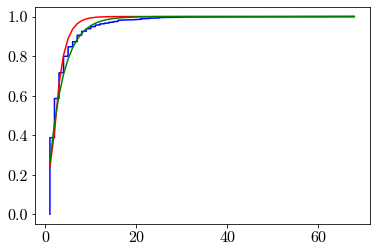

In [45]:
def double_exponential(x, mean, tau):
    return 0.5 + 0.5 * np.sign(x - mean) * (1 - np.exp(-np.abs(x - mean) / tau))


def exponential(x, a):
    return 1 - np.exp(-a * x)


res_time = np.array(res_dict_list[2][str(1)]["res_times_filtered"])
res_time_sorted = np.sort(res_time)
# calculate the proportional values of samples
p = 1.0 * np.arange(len(res_time)) / (len(res_time) - 1)
popt, pcov = curve_fit(double_exponential, res_time_sorted, p)
popt_exp, pcov_exp = curve_fit(exponential, res_time_sorted, p)
plt.plot(res_time_sorted, p, "b-", label="data")
plt.plot(res_time_sorted, double_exponential(res_time_sorted, *popt), "r-")
plt.plot(res_time_sorted, exponential(res_time_sorted, *popt_exp), "g-")

LVRQL cluster 0 double exp 1/tau: [2.4250012 2.0279066] 
LVRQL cluster 1 double exp 1/tau: [1.45351647 0.9698821 ] 
LVRQL cluster 2 double exp 1/tau: [1.02512041 0.36095923] 
GLAVRSQLL cluster 0 double exp 1/tau: [3.70218579 3.42852972] 
GLAVRSQLL cluster 1 double exp 1/tau: [1.23053753 0.77060975] 
GLAVRSQLL cluster 2 double exp 1/tau: [1.1611476  0.68422939] 
WT cluster 0 double exp 1/tau: [2.24152276 1.70957874] 
WT cluster 1 double exp 1/tau: [1.50843893 0.98375314] 
WT cluster 2 double exp 1/tau: [1.00476577 0.09767629] 
LVRQ cluster 0 double exp 1/tau: [2.15046461 1.55632235] 
LVRQ cluster 1 double exp 1/tau: [1.23032639 0.7218452 ] 
LVRQ cluster 2 double exp 1/tau: [1.12448446 0.62609477] 
GLVRSQL cluster 0 double exp 1/tau: [2.26306274 1.65191847] 
GLVRSQL cluster 1 double exp 1/tau: [1.3112524  0.82567059] 
GLVRSQL cluster 2 double exp 1/tau: [1.07437475 0.50078875] 


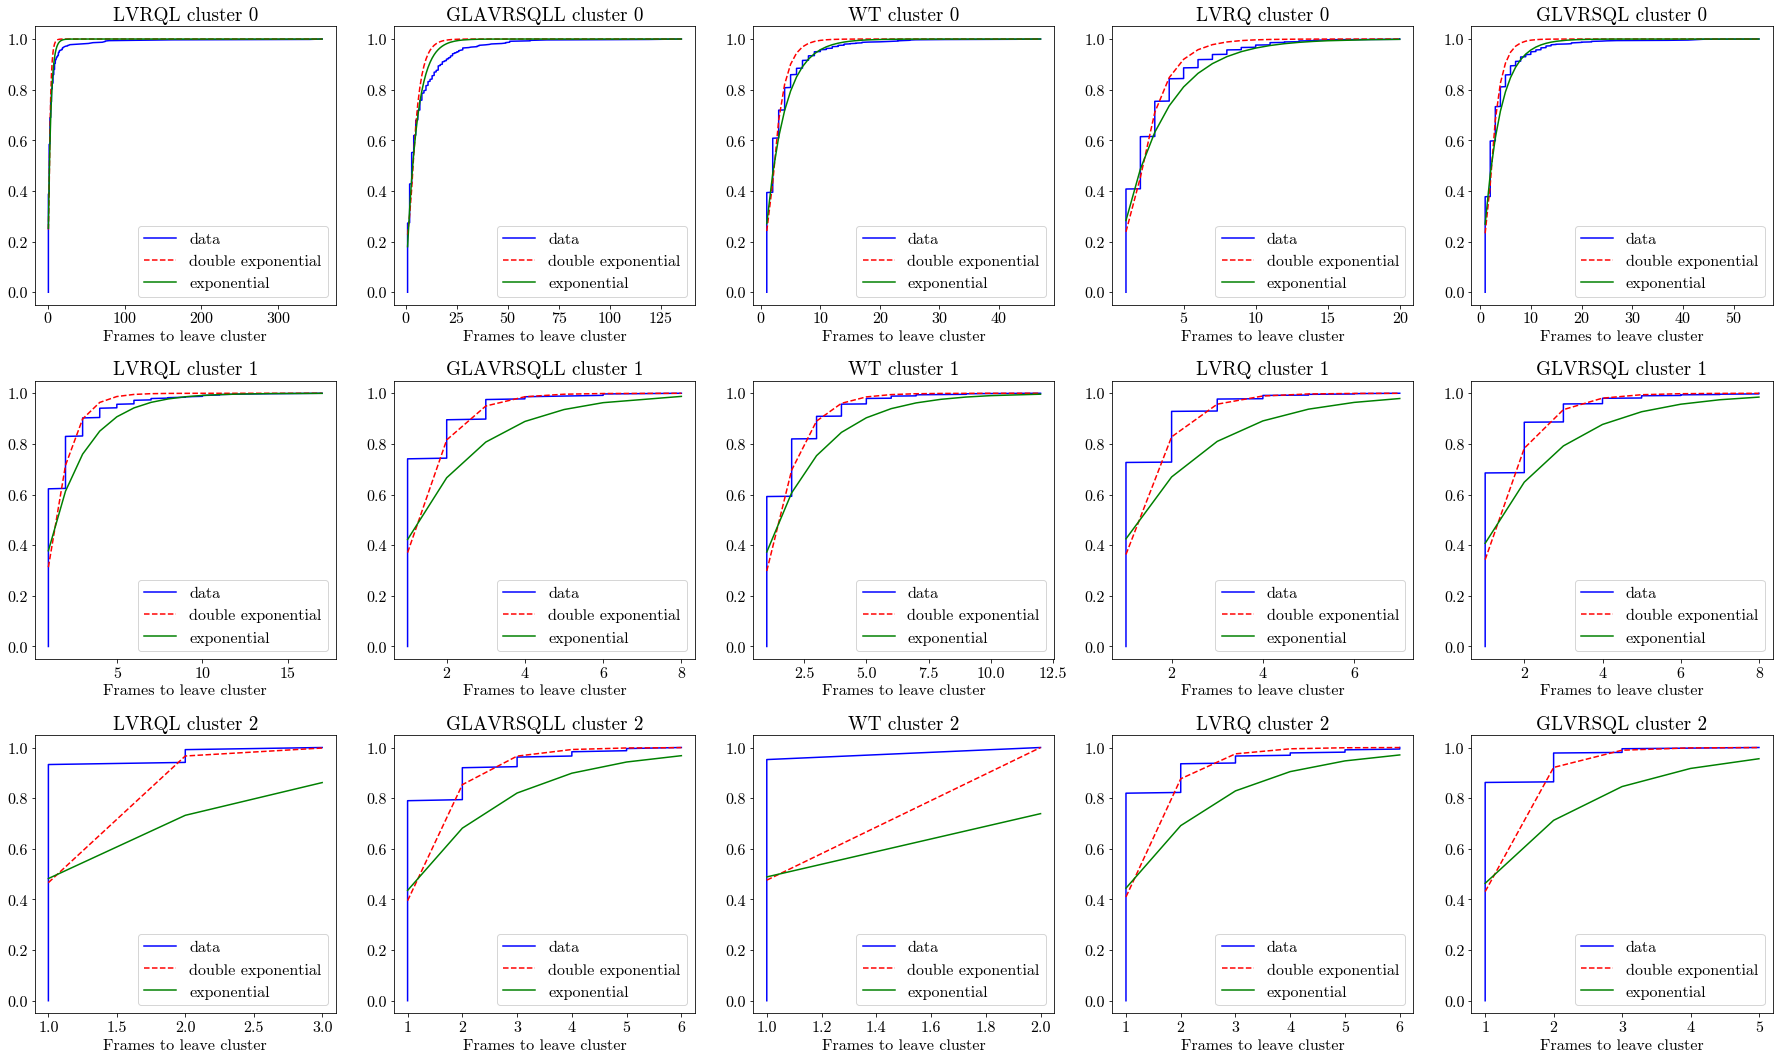

In [50]:
import matplotlib.pyplot as plt

tau_dict = {}
max_num_cluster = 3
# create subplots of max_num_cluster x len(res_dict_list)
fig, axs = plt.subplots(
    max_num_cluster, len(res_dict_list), figsize=(25, 15), sharex=False, sharey=False
)
name_dict = [i["0"]["name"].split("-")[0][2:] for i in res_dict_list]

for ind, res_dict in enumerate(res_dict_list):
    # set column title
    for i in range(max_num_cluster):
        # get the ith key in res_dict
        key_mapped = str(list(res_dict.keys())[i])
        # print(key_mapped)
        if str(i) in res_dict:
            if i < len(res_dict):
                res_time = np.array(res_dict[key_mapped]["res_times"])
                res_time_sorted = np.sort(res_time)
                # calculate the proportional values of samples
                p = 1.0 * np.arange(len(res_time)) / (len(res_time) - 1)
                # get function parameters
                popt, pcov = curve_fit(double_exponential, res_time_sorted, p)
                popt_exp, pcov_exp = curve_fit(exponential, res_time_sorted, p)
                axs[i, ind].plot(res_time_sorted, p, "b-", label="data")
                axs[i, ind].plot(
                    res_time_sorted,
                    double_exponential(res_time_sorted, *popt),
                    "r-",
                    linestyle="dashed",
                    label="double exponential",
                )
                axs[i, ind].plot(
                    res_time_sorted,
                    exponential(res_time_sorted, *popt_exp),
                    "g-",
                    label="exponential",
                )
                if name_dict[ind] not in tau_dict.keys():
                    tau_dict[name_dict[ind]] = []
                tau_dict[name_dict[ind]].append(1 / popt[1])
                # print(
                #    "{} cluster {} double exp 1/tau: {} exp 1/tau: {}".format(
                #        name_dict[ind], i, 1 / popt[1], 1 / popt_exp[0]
                #    )
                # )

                print(
                    "{} cluster {} double exp 1/tau: {} ".format(
                        name_dict[ind], i, popt
                    )
                )

                # add legend
                axs[i, ind].legend()
                axs[i, ind].set_xlabel("Frames to leave cluster")
                axs[i, ind].set_title("{} cluster {}".format(name_dict[ind], i))

            # axs[i, ind].set_visible(False)
            # axs[i, ind].set_visible(False)
plt.tight_layout()


In [40]:
# plot the tau histogram of first key in tau_dict as categorical histogram w bins = len(tau_dict.keys())
# unfiltered
tau_dict

{'LVRQL': [0.49311935815767083, 1.031053151776113, 2.770395949056653],
 'GLAVRSQLL': [0.2916702151102591, 1.2976736912701323, 1.4614981726227398],
 'WT': [0.5849394218523493, 1.0165151806162813, 10.23789906558861],
 'LVRQ': [0.6425404103314405, 1.3853385699232026, 1.5972022942333255],
 'GLVRSQL': [0.6053567514031487, 1.211136762039364, 1.996849975823392]}

In [76]:
# filtered
tau_dict

{'LVRQL': [0.49311935815767083, 1.031053151776113, 2.770395949056653],
 'GLAVRSQLL': [0.2916702151102591, 1.2976736912701323, 1.4614981726227398],
 'WT': [0.5849394218523493, 1.0165151806162813, 10.23789906558861],
 'LVRQ': [0.6425404103314405, 1.3853385699232026, 1.5972022942333255],
 'GLVRSQL': [0.6053567514031487, 1.211136762039364, 1.996849975823392]}

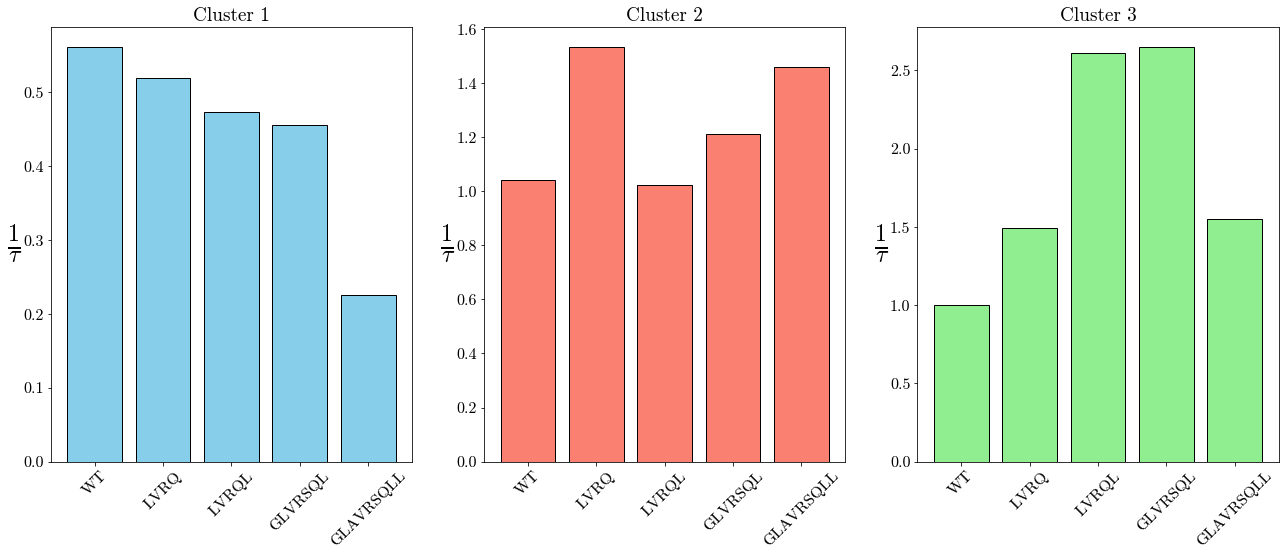

In [83]:
import matplotlib.pyplot as plt
import numpy as np

data = {
    "WT": [0.5604713169694813, 1.0414760303187773, 1.0],
    "LVRQ": [0.5192955274038389, 1.5331360909474914, 1.4900276275799502],
    "LVRQL": [0.47256992188728375, 1.0241877197801184, 2.6106523580397347],
    "GLVRSQL": [0.4548574426702733, 1.214185542852645, 2.646355058556044],
    "GLAVRSQLL": [0.22477517634996935, 1.4615999913647102, 1.546651192060528],
}

# Extract the values for each plot
plot1_values = [data[key][0] for key in data]
plot2_values = [data[key][1] for key in data]
plot3_values = [data[key][2] for key in data]

# Create separate categorical bar plots for each set of values
plt.figure(figsize=(22, 8))

plt.subplot(131)
plt.bar(data.keys(), plot1_values, color="skyblue", edgecolor="black")
plt.title("Cluster 1")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.ylabel(
    r"$\frac{1}{\mathrm{\tau}}$", fontsize=34, rotation="horizontal", va="center"
)
plt.gca().yaxis.set_label_coords(-0.1, 0.5)  # Adjust y-label position

plt.subplot(132)
plt.bar(data.keys(), plot2_values, color="salmon", edgecolor="black")
plt.title("Cluster 2")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.ylabel(
    r"$\frac{1}{\mathrm{\tau}}$", fontsize=34, rotation="horizontal", va="center"
)
plt.gca().yaxis.set_label_coords(-0.1, 0.5)  # Adjust y-label position

plt.subplot(133)
plt.bar(data.keys(), plot3_values, color="lightgreen", edgecolor="black")
plt.title("Cluster 3")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.ylabel(
    r"$\frac{1}{\mathrm{\tau}}$", fontsize=34, rotation="horizontal", va="center"
)
plt.gca().yaxis.set_label_coords(-0.1, 0.5)  # Adjust y-label position

# plt.tight_layout()
plt.show()

In [9]:
bounary_list_inds = []
# construct networkx graph
import networkx as nx

# compute the 0.25 quantile of the distance matrix
import numpy as np

cutoff_distance = np.quantile(distance_matrix, 0.1)

G = nx.Graph()
G.add_nodes_from(range(len(labels)))
for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        if distance_matrix[i, j] < cutoff_distance:
            G.add_edge(i, j, weight=distance_matrix[i, j])
# add the labels to the graph
for i in range(len(labels)):
    G.nodes[i]["label"] = labels[i]

# iterate through the nodes and neighbors
for i in range(len(labels)):
    # if i<20:
    neighbor_nodes = list(G.neighbors(i))
    neighbor_labels = [G.nodes[j]["label"] for j in neighbor_nodes]
    neighbor_setlist = list(set(neighbor_labels))
    self_label = G.nodes[i]["label"]
    if len(neighbor_setlist) > 0:
        if len(neighbor_setlist) > 1:
            bounary_list_inds.append(i)
        else:
            if self_label != neighbor_setlist:
                bounary_list_inds.append(i)
print(len(bounary_list_inds))

boundary_file_names = []
for i in bounary_list_inds:
    boundary_file_names.append(topo_files[i])

2937


In [169]:
compress_dictionary["boundary_inds"] = bounary_list_inds


def get_run_number(file, run_key="run"):
    # get the run number
    run_number = file.split("-")
    # get the string with run_key in it
    run_number = [i for i in run_number if run_key in i]
    # remove the run_key
    run_number = run_number[0].replace(run_key, "")
    # convert to integer
    run_number = int(run_number)
    return run_number


def compute_resonance_times(files, full_files, run_key="run", split_by_run=False):
    """compute the resonance times for a given cluster, separated by run_key
    Takes:
        files: list of files in a cluster
        full_files: list of all files
        run_key: string that separates the run number from the rest of the file name
    """
    res_dict = {}

    res_time_temp = 0
    for ind_file_cluster, file in enumerate(files[:-1]):
        res_time_temp += 1
        run_number = get_run_number(file, run_key=run_key)
        # check if run_number is in res_dict
        if run_number not in res_dict.keys():
            res_dict[run_number] = []
        # print(ind_file_cluster)
        # check if the next file in files is the next file in full_files
        next_file = files[ind_file_cluster + 1]
        # get the index of the next_file in full_files
        ind_next_file = full_files.index(next_file)
        ind_current_file = full_files.index(file)
        # check if the next file is the next file in full_files
        # print(ind_next_file - ind_current_file)
        if ind_next_file - ind_current_file != 1:
            # if so, append the res_time_temp to the list
            res_dict[run_number].append(res_time_temp)
            # reset the res_time_temp
            res_time_temp = 0

    # compute mean and number of samples in each run
    for k, v in res_dict.items():
        res_dict[k] = {"mean": np.mean(v), "n_entries": len(v)}

    if split_by_run:
        return res_dict
    else:
        res_dict_aggregate = {"mean": [], "n_entries": []}
        for k, v in res_dict.items():
            res_dict_aggregate["mean"].append(v["mean"])
            res_dict_aggregate["n_entries"].append(v["n_entries"])

        res_dict_aggregate["mean"] = np.mean(res_dict_aggregate["mean"])
        res_dict_aggregate["n_entries"] = np.sum(res_dict_aggregate["n_entries"])
        return res_dict_aggregate


def filtered_resonance_analysis(compress_dictionary, run_key="run"):
    """
    Computes simple statistics on mean resonance times in each cluster
    """
    assert (
        "boundary_names" in compress_dictionary.keys()
    ), "need indicies of boundary points in dictionary"

    # first go through each cluster and collect the names of the files and order them
    full_files = []
    for k, v in compress_dictionary.items():
        # check if k is a number
        if type(k) == int:
            files_single = v["files"]
            full_files.extend(files_single)
        elif k.isnumeric():
            files_single = v["files"]
            full_files.extend(files_single)
    # remove duplicates
    full_files = list(set(full_files))
    # sort the files
    full_files.sort()
    # filter out the boundary points
    full_files = [
        i for i in full_files if i not in compress_dictionary["boundary_names"]
    ]
    # get the number of files
    n_files = len(full_files)
    print("number of topo files in compressed dict: {}".format(n_files))

    # go through each cluster
    for k, v in compress_dictionary.items():
        # check if k is a number
        # print(k)

        if k.isnumeric():
            compress_dictionary[k]["resonance_info_filtered"] = compute_resonance_times(
                [
                    i
                    for i in v["files"]
                    if i not in compress_dictionary["boundary_names"]
                ],
                full_files,
                run_key=run_key,
                split_by_run=False,
            )
            # print the results for this cluster
            print(
                "cluster {}: {}".format(
                    k, compress_dictionary[k]["resonance_info_filtered"]
                )
            )

    return compress_dictionary